In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import matplotlib.cm as cm
import random
import scipy.io as sio
import shap
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed) 
set_seed(3407)

In [16]:
data = sio.loadmat('shapValues_plot.mat')
shap_struct = data['shapValues_plot']
shap_struct
feature_values=shap_struct[0][0][0]
shap_values=shap_struct[0][0][1]
feature_names_raw=shap_struct[0][0][2]
feature_names = [str(f[0]) for f in feature_names_raw[0]]
print(feature_names)
mean_shap_value=np.mean(abs(shap_values),axis=0)
mean_shap_value

['Slag (%)', 'Red Mud (%)', 'Fly Ash (%)', 'Cure Age (d)', 'Water–Binder Ratio', 'Activator Modulus', 'Activator Concentration (mol/L)']


array([0.02910256, 0.1151263 , 0.03240636, 0.44661262, 0.24479527,
       0.19234664, 0.24011459])

## 单模型SHAP分析

### 柱状渐变的蜂巢+柱状SHAP分析图

C:\Users\UserX\AppData\Local\Temp\ipykernel_32896\1403365508.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
C:\Users\UserX\AppData\Local\Temp\ipykernel_32896\1403365508.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


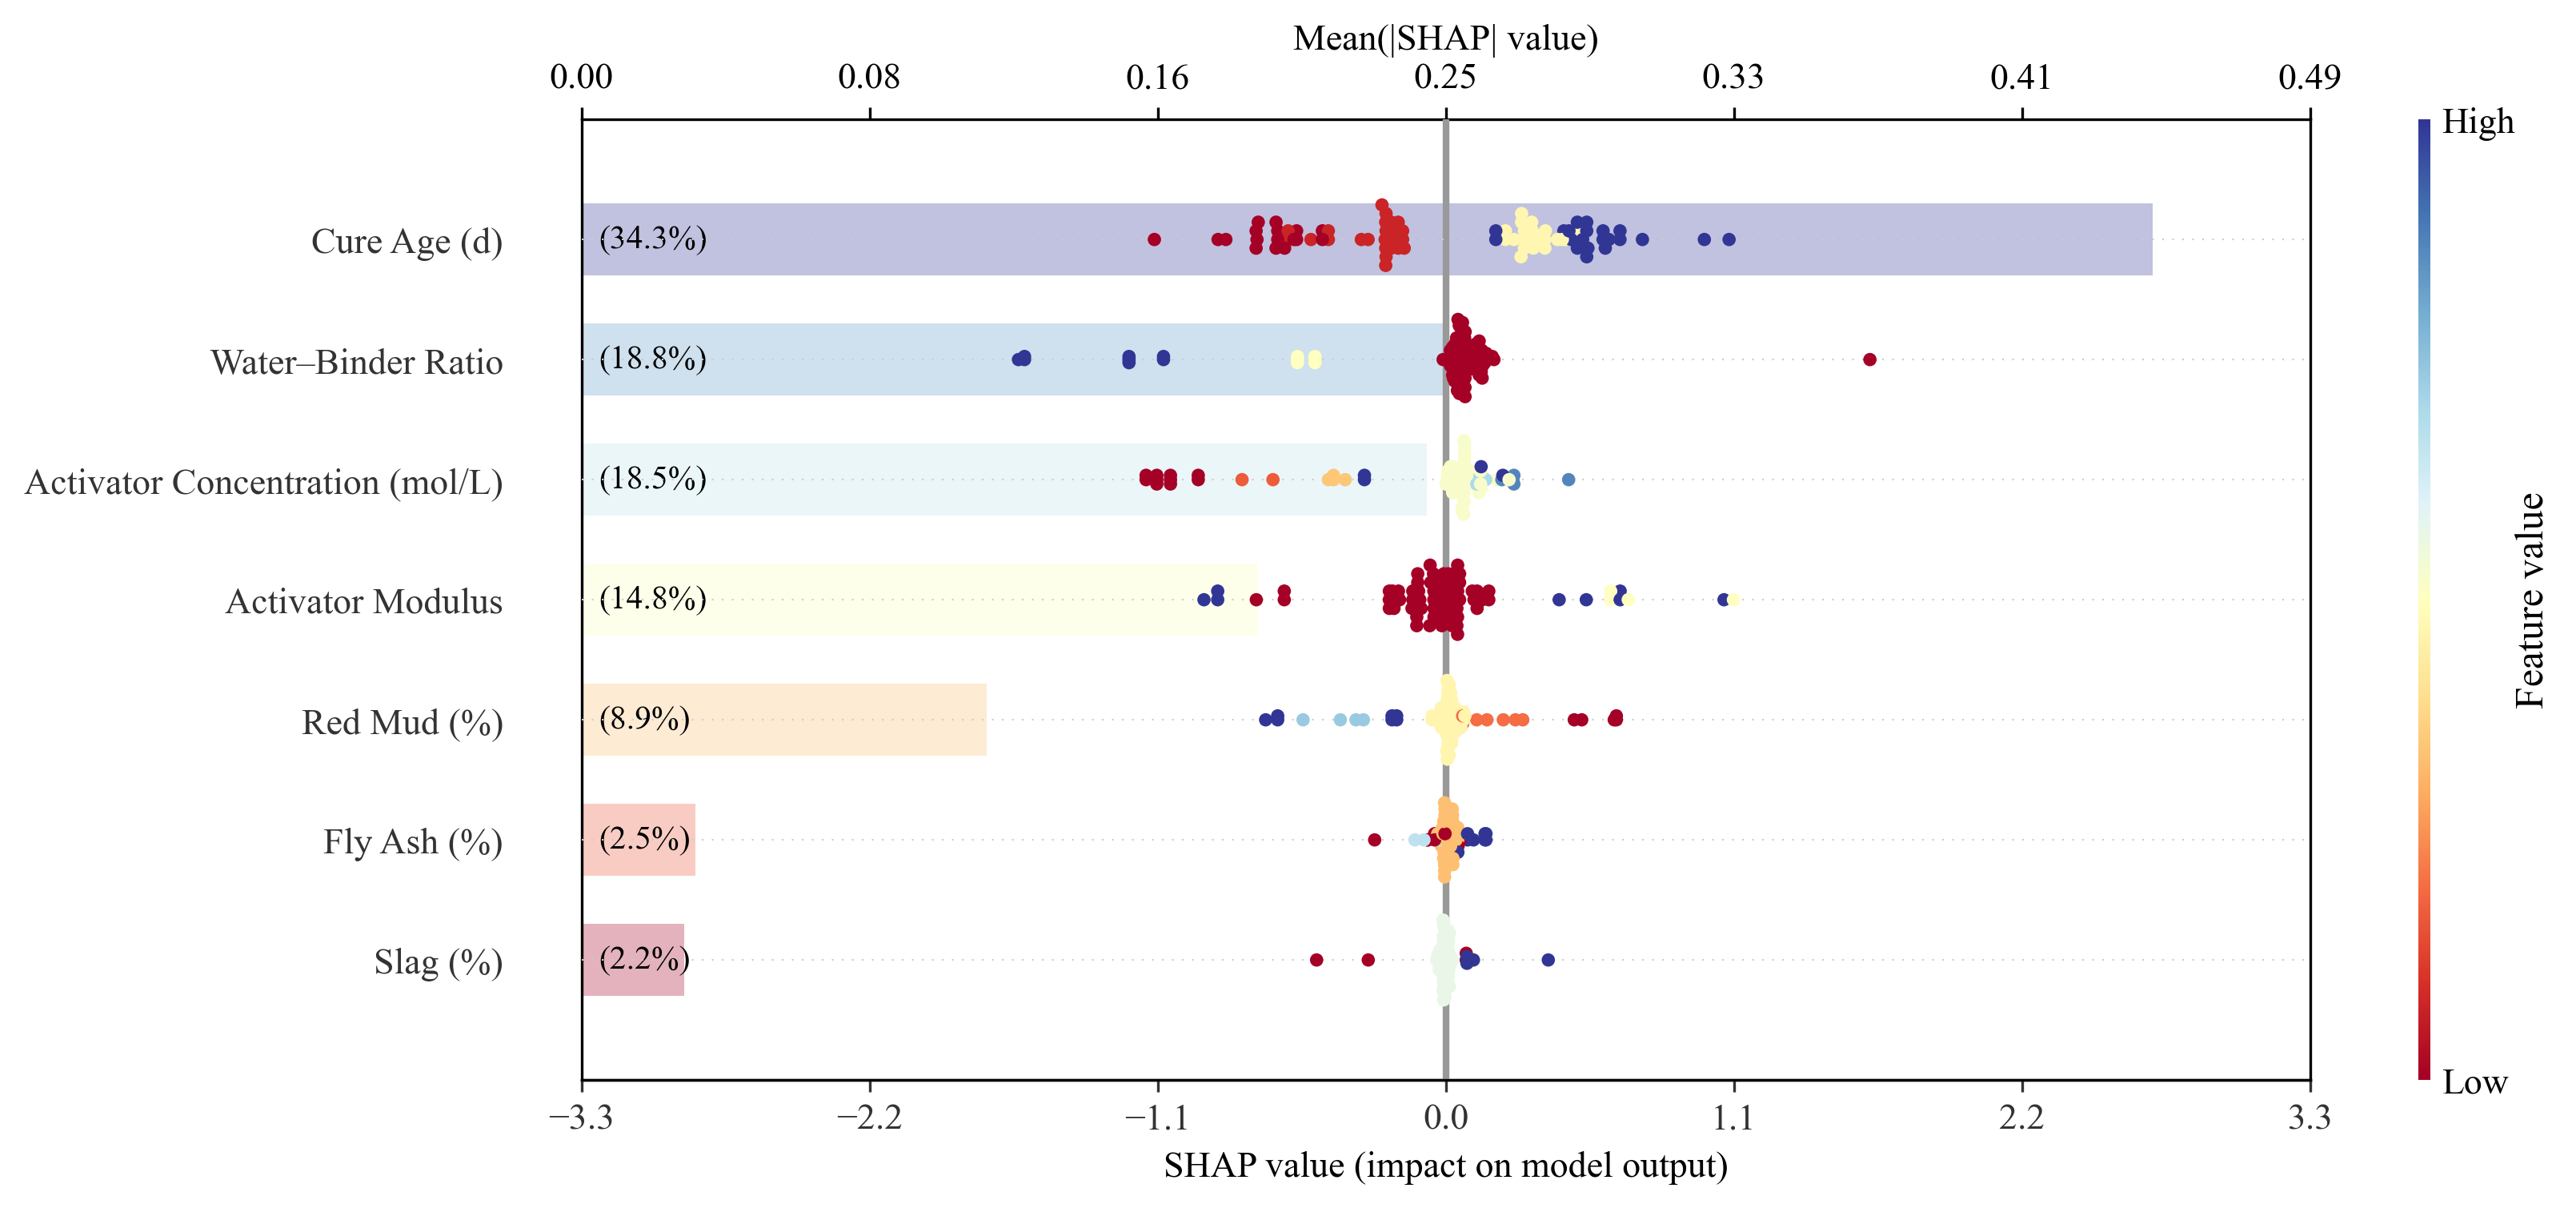

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import matplotlib.cm as cm
# ======= 数据准备 =======
df_test_list_X=pd.DataFrame(feature_values,columns=feature_names)
# ======= 数据准备 =======
features =feature_names
shap_summary = pd.DataFrame({
    "Feature": features,
    "MeanSHAP": mean_shap_value
}).sort_values("MeanSHAP", ascending=False)

sorted_feats = shap_summary["Feature"].values
feat_idx = [list(features).index(f) for f in sorted_feats]

X_test_sorted = df_test_list_X[sorted_feats]
# 确保 SHAP 值是 numpy array
shap_vals = shap_values.values if hasattr(shap_values, "values") else np.asarray(shap_values)
shap_vals_sorted = shap_vals[:, feat_idx]

# 计算 SHAP 平均值与百分比
mean_shap = shap_summary["MeanSHAP"].values
mean_shap_pct = mean_shap / mean_shap.sum() * 100

# ======= 绘图准备 =======
fig = plt.figure(figsize=(15, 5), dpi=300)
ax_bee = fig.add_axes([0.3, 0.1, 0.6, 0.8])  # beeswarm 主坐标轴

   #配色   viridis  Spectral   coolwarm  RdYlGn  RdYlBu  RdBu  RdGy  PuOr  BrBG PRGn  PiYG 
cmap_name="RdYlBu"
cmap = cm.get_cmap(cmap_name)   

shap.plots._utils.colors.red_blue = cmap_name
cmap1 = plt.get_cmap(cmap_name)


explainer_data = shap.Explanation(
    values=shap_vals_sorted,
    data=X_test_sorted.values,
    feature_names=sorted_feats
)

# 绘制 beeswarm 图（自动生成 y 轴坐标）
shap.plots.beeswarm(explainer_data, ax=ax_bee, show=False, plot_size=None)

# 获取 beeswarm 图的 y 轴信息（用于柱状图对齐）
y_coords = ax_bee.get_yticks()
y_labels = [tick.get_text() for tick in ax_bee.get_yticklabels()]

# 如果 SHAP 没生成标签，则使用特征名
y_order = y_labels if any(lbl != "" for lbl in y_labels) else sorted_feats

# 按 beeswarm 的顺序获取 SHAP 均值和百分比
shap_mean_map = dict(zip(sorted_feats, mean_shap))
shap_pct_map = dict(zip(sorted_feats, mean_shap_pct))
bar_widths = [shap_mean_map.get(lbl, 0) for lbl in y_order]
bar_pcts1 = [shap_pct_map.get(lbl, 0) for lbl in y_order]
bar_pcts=bar_pcts1.copy()
bar_pcts[0]=100-np.sum(bar_pcts[1:])
# ======= 绘制水平柱状图（与 beeswarm 对齐） =======
ax_bar = ax_bee.twiny()
ax_bar.set_zorder(0)
ax_bee.set_zorder(1)
ax_bee.patch.set_alpha(0)  # 让柱状图背景透出来
colors = cmap1(np.linspace(0, 1, len(y_coords)))  # 从colormap中均匀取色

# 绘制水平柱状图
ax_bar.barh(
    y=y_coords,
    width=bar_widths,
    height=0.6,
    alpha=0.3,
    color=colors,
    edgecolor="none",
    zorder=0
)

# 设置柱状图横坐标范围
bar_xlim = max(bar_widths) * 1.1 if max(bar_widths) > 0 else 1.0
ax_bar.set_xlim(0, bar_xlim)
ax_bar.set_xticks(np.linspace(0, bar_xlim, 7))
ax_bar.set_xticklabels([f"{x:.2f}" for x in np.linspace(0, bar_xlim, 7)], fontsize=11)
ax_bar.set_xlabel("Mean(|SHAP| value)", fontsize=11)
ax_bar.set_yticks([])

# ======= 同步 beeswarm 图属性 =======
# beeswarm 横坐标范围 & 标签
shap_xlim = round(abs(shap_vals_sorted).max() * 2, 1)
ax_bee.set_xlim(-shap_xlim, shap_xlim)
ax_bee.set_xticks(np.linspace(-shap_xlim, shap_xlim, 7))
ax_bee.set_xlabel("SHAP value (impact on model output)", fontsize=11)

# 更新 beeswarm y 轴标签
ax_bee.set_yticks(y_coords)
ax_bee.set_yticklabels(y_order, fontsize=11)

# 保证两个 y 轴范围一致
ax_bar.set_ylim(ax_bee.get_ylim())

# ======= 在柱状图旁显示百分比 =======
for y, p in zip(y_coords, bar_pcts):
    ax_bar.text(0.01 * bar_xlim, y, f"({p:.1f}%)", va="center", ha="left", fontsize=10, color="black")

# ======= 布局优化并显示 =======
plt.tight_layout()
plt.show()


### 单特征依赖图

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Processing feature: Slag (%)


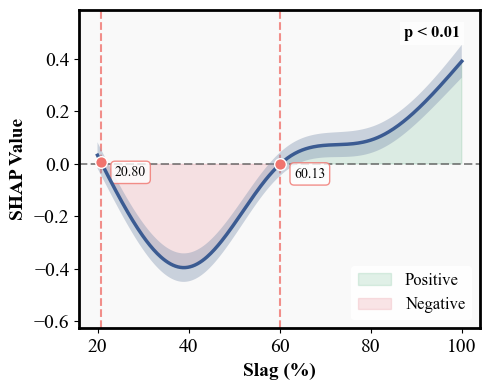

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Processing feature: Red Mud (%)


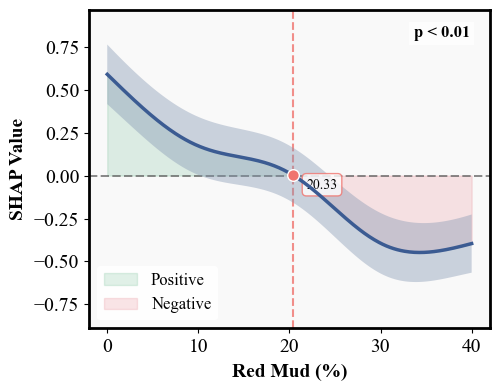

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Processing feature: Fly Ash (%)


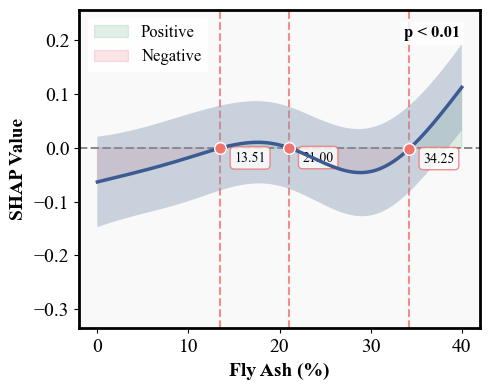

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Processing feature: Cure Age (d)


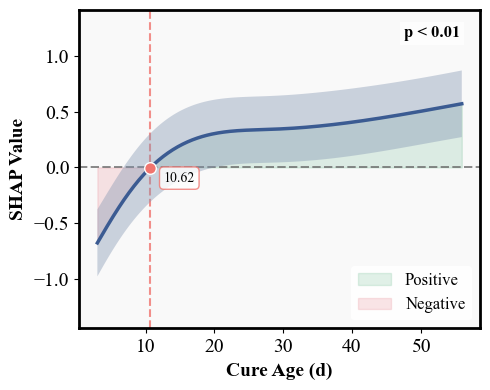

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Processing feature: Water–Binder Ratio


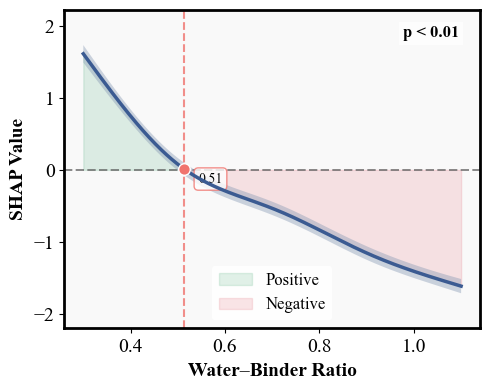

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Processing feature: Activator Modulus


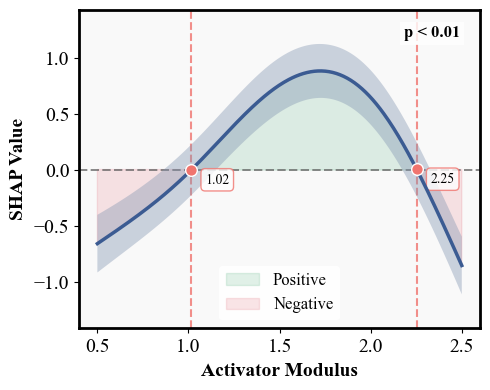

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Processing feature: Activator Concentration (mol/L)


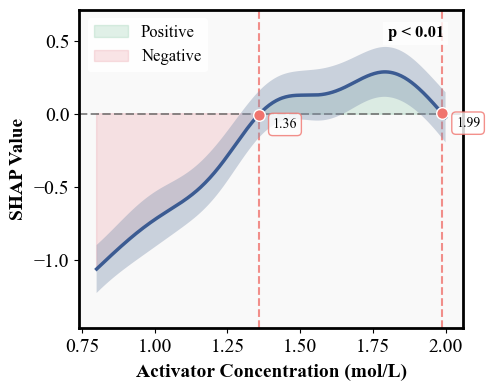

In [ ]:
from pygam import LinearGAM, s
from matplotlib import rcParams
from matplotlib.ticker import AutoMinorLocator

# ======================
plt.style.use('default')
rcParams.update({
    'font.family': 'Times New Roman',  # 改为Times New Roman字体
    'font.size': 10,  # 基础字体加大1号
    'axes.labelsize': 14,  # 坐标轴标签字体加大
    'axes.titlesize': 16,  # 标题字体加大
    'xtick.labelsize': 14,  # x轴刻度标签加大
    'ytick.labelsize': 14,  # y轴刻度标签加大
    'legend.fontsize': 12,  # 图例字体加大
    'lines.linewidth': 2,  # 加粗曲线
    'grid.linewidth': 0.7,  # 网格线加粗
    'lines.markersize': 6,
    'savefig.dpi': 900,
    'savefig.format': 'pdf',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.spines.top': True,  # 显示所有边框
    'axes.spines.right': True,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
})


# ======================
COLOR_PALETTE = {
    'main': '#3b5b92',  # 主色 - 优雅深蓝色
    'ci': '#8395b1',  # 置信区间 - 柔和蓝灰色
    'positive': '#36a168',  # 正SHAP - 翡翠绿色
    'negative': '#e05263',  # 负SHAP - 玫瑰红色
    'data': '#e0e0e0',  # 数据点 - 淡灰色
    'zero_line': '#666666',  # 零线 - 中灰色
    'tipping_point': '#f0746e',  # 临界点 - 珊瑚色
    'background': '#f9f9f9'  # 背景色 - 几乎白色背景
}


# ======================
# 增强的GAM拟合函数
# ======================
def fit_enhanced_gam(X, y):
    gam = LinearGAM(s(0, n_splines=20, spline_order=3, lam=3)).gridsearch(X, y)
    return gam



# ======================
def plot_scientific_style(ax, XX, y_pred, ci, feature_name, tipping_points=None, p_value=None):
    """全边框科研风格绘图"""

    # 设置背景色
    ax.set_facecolor(COLOR_PALETTE['background'])
    fig = plt.gcf()
    fig.patch.set_facecolor('white')

    # 1. 绘制零线
    ax.axhline(0, color=COLOR_PALETTE['zero_line'],
               linestyle=(0, (5, 2)), linewidth=1.2,
               alpha=0.9, zorder=2)

    # 2. 绘制置信区间（渐变填充）- 移除标签
    ax.fill_between(XX.flatten(), ci[:, 0], ci[:, 1],
                    color=COLOR_PALETTE['ci'],
                    alpha=0.4, zorder=3,
                    edgecolor='none')

    # 3. 主趋势线 - 移除标签
    ax.plot(XX, y_pred, color=COLOR_PALETTE['main'],
            linewidth=2.5, zorder=5)

    # 4. 临界点标记和坐标 - 只显示数值
    if tipping_points:
        for i, (x, y) in enumerate(tipping_points):
            ax.axvline(x, color=COLOR_PALETTE['tipping_point'],
                       linestyle='--', linewidth=1.5, alpha=0.8)
            ax.scatter(x, y, color=COLOR_PALETTE['tipping_point'],
                       s=70, zorder=6, edgecolor='white',
                       linewidth=1)

            # 添加坐标文本注释 - 只显示数值
            ax.annotate(f'{x:.2f}',
                        xy=(x, y),
                        xytext=(10, -10),  # 文本偏移，避免重叠
                        textcoords='offset points',
                        fontsize=10,
                        bbox=dict(boxstyle="round,pad=0.3",
                                  facecolor='white',
                                  alpha=0.8,
                                  edgecolor=COLOR_PALETTE['tipping_point']))

    # 5. 正负区域半透明渐变 - 保留标签
    pos_mask = y_pred > 0
    if any(pos_mask):
        ax.fill_between(XX.flatten(), 0, y_pred,
                        where=pos_mask,
                        color=COLOR_PALETTE['positive'],
                        alpha=0.15, zorder=0,
                        label='Positive')  # 保留正区域的图例标签

    neg_mask = y_pred <= 0
    if any(neg_mask):
        ax.fill_between(XX.flatten(), 0, y_pred,
                        where=neg_mask,
                        color=COLOR_PALETTE['negative'],
                        alpha=0.15, zorder=0,
                        label='Negative')  # 保留负区域的图例标签

    # 6. 删除次刻度线
    ax.tick_params(which='minor', size=0)

    # 7. 添加坐标轴标签
    ax.set_xlabel(feature_name, labelpad=5, fontweight='bold')
    ax.set_ylabel('SHAP Value', labelpad=5, fontweight='bold')

    # 8. 设置坐标轴边框加粗
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    # 9. 添加p值
    if p_value is not None:
        p_text = f"p < 0.01" if p_value < 0.01 else f"p = {p_value:.3e}"
        ax.text(0.95, 0.95, p_text,
                transform=ax.transAxes, ha='right', va='top',
                fontsize=12, fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=3))

    # 10. 显示图例，只显示Positive和Negative
    ax.legend(loc='best', frameon=True, framealpha=0.95, edgecolor='none')


# 遍历所有特征
# for n in range(0,len(df_test_list_X.columns)):
feature_num=12     #遍历4个特征
if feature_num>len(df_test_list_X.columns):
    feature_num=len(df_test_list_X.columns)
for n in range(0,feature_num):
    feature=df_test_list_X.columns[n]
    print(f"Processing feature: {feature}")

    # 准备数据
    X_feature = df_test_list_X[feature].values.reshape(-1, 1)
    y_shap = shap_values[:,n].reshape(-1, 1)

    # 增强GAM拟合
    gam = fit_enhanced_gam(X_feature, y_shap)
    R_squared = gam.statistics_['pseudo_r2']['explained_deviance'] * 100

    # 提取p值
    p_value = gam.statistics_['p_values'][0]  # 假设该特征是模型中的第一个

    # 生成预测网格
    XX = gam.generate_X_grid(term=0, n=300)
    y_pred = gam.predict(XX)
    ci = gam.prediction_intervals(XX, width=0.95)

    # 查找临界点
    zero_crossings = np.where(np.diff(np.sign(y_pred)))[0]
    tipping_points = [(XX[i][0], y_pred[i]) for i in zero_crossings if i < len(XX)]


    # 创建图形（正方形比例）
    fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

    # 专业绘图
    plot_scientific_style(ax, XX, y_pred, ci, feature,
                            tipping_points=tipping_points,
                            p_value=p_value)

    # 添加统计信息
   # ax.text(0.05, 0.95,
              #  f"$R^2$ = {R_squared:.1f}%",
              #  transform=ax.transAxes,
              #  ha='left', va='top',
             #   fontsize=12,
             #   bbox=dict(facecolor='white', alpha=0.9,
             #               edgecolor='none', pad=3))

    # 设置坐标轴范围
    y_padding = 0.15 * np.ptp(y_shap)
    y_min = min(ci[:, 0].min(), y_shap.min()) - y_padding
    y_max = max(ci[:, 1].max(), y_shap.max()) + y_padding
    ax.set_ylim([y_min, y_max])

    # 保存图形
    plt.tight_layout()
    plt.show()
    # fig.savefig(f"{output_dir}/{feature}_shap_plot.pdf")
    # plt.close(fig)

